In [79]:
# Available regions: 'Hirakud', 'Basantpur', 'Ghatora', 'Kurubhata', 'Rajim', 'Simga', 'Sundargarh'
REGION = 'Hirakud'

# Available percentage for training: 20, 50, 80, 100
training_percentage = 20

In [80]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from numpy import array
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import find_peaks


# Set random seeds for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Base paths
DATA_DIR = Path('Data')
MODEL_DIR = Path('models')
MODEL_DIR.mkdir(exist_ok=True)

# Model and training parameters
N_STEPS_IN, N_STEPS_OUT = 30, 10 # Look back 30 days to predict next 5 days
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.0001

In [81]:
# Available regions: 'Hirakud', 'Basantpur', 'Ghatora', 'Kurubhata', 'Rajim', 'Simga', 'Sundargarh'
# REGION = 'Kurubhata'

# Base configuration
BASE_FEATURES = {
    # 'Hirakud': {
    #     'features': ['Mean_areal_rainfall_upper', 'Inflow', 'Sundargarh', 'Kurubhata'],
    #     'target': 'Inflow'
    # },
    'Hirakud': {
        'features': ['Mean_areal_rainfall_upper', 'Inflow'],
        'target': 'Inflow'
    },
    'Basantpur': {
        'features': ['Mean_areal_rainfall_upper', 'Basantpur'],
        'target': 'Basantpur'
    },
    # 'Basantpur': {
    #     'features': ['Mean_areal_rainfall_upper', 'Basantpur', 'Rajim', 'Simga', 'Ghatora'],
    #     'target': 'Basantpur'
    # },
    'Ghatora': {
        'features': ['Mean_areal_rainfall_upper', 'Ghatora'],
        'target': 'Ghatora'
    },
    'Kurubhata': {
        'features': ['Mean_areal_rainfall_upper', 'Kurubhata'],
        'target': 'Kurubhata'
    },
    'Rajim': {
        'features': ['Mean_areal_rainfall_upper', 'Rajim'],
        'target': 'Rajim'
    },
    'Simga': {
        'features': ['Mean_areal_rainfall_upper', 'Simga'],
        'target': 'Simga'
    },
    'Sundargarh': {
        'features': ['Mean_areal_rainfall_upper', 'Sundargarh'],
        'target': 'Sundargarh'
    }
}

# Generate output columns dynamically
def get_output_columns(features, region):
    columns = {'Mean_areal_rainfall_upper': 'rainfall'}
    for feat in features:
        if feat != 'Mean_areal_rainfall_upper':
            columns[feat] = feat.lower() + ('_discharge' if feat != 'rainfall' else '')
    return columns

# Build final config
current_config = BASE_FEATURES.get(REGION)
if not current_config:
    raise ValueError(f"Configuration for region '{REGION}' not found.")

# Set global variables
FEATURES = current_config['features']
TARGET_FEATURE = current_config['target']
OUTPUT_COLUMNS = get_output_columns(FEATURES, REGION)
TARGET_FEATURE_NAME = OUTPUT_COLUMNS[TARGET_FEATURE]
FEATURES_TO_USE = list(OUTPUT_COLUMNS.values())
MODEL_SAVE_PATH = f"best_mlp_mann_model_{REGION}.pth"
# RAW_TEST_FILE_PATH = f"Data/raw_test_y_{REGION.lower()}.csv"
RAW_TEST_FILE_PATH = f"Data/raw_test_y_{REGION.lower()}_10_steps_ahead.csv"


# Load and prepare data
data = pd.read_excel('Data/new data.xlsx')
data = data[['Date'] + FEATURES].rename(columns=OUTPUT_COLUMNS)
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date').ffill().bfill()

/var/folders/_w/4xfs9wld05nfzlbq4p03y6z80000gn/T/ipykernel_14818/3739216576.py:71: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Date'])


In [82]:
def get_train_test_split(data, training_percentage=100):
    # Define the split points based on percentage
    split_dates = {
        100: '2000-01-01',  # 100% of data -> 4017 days
        80: '2002-01-01',   # 80% of data -> 3286 days
        50: '2005-01-01',    # 50% of data -> 2190 days
        20: '2008-01-01'
    }
    
    if training_percentage not in split_dates:
        raise ValueError("training_percentage must be one of: 50, 80, or 100")      # Would like to change to a continous form
    
    # Split the data
    train_start = split_dates[training_percentage]
    data_train = data.loc[train_start:'2010-12-31'].copy()
    data_test = data.loc['2011-01-01':'2014-12-31'].copy()
    
    return data_train, data_test

# usage:
# training_percentage = 50
data_train, data_test = get_train_test_split(data, training_percentage)

# Keep raw test target before processing
raw_data_test_target = data_test[[TARGET_FEATURE_NAME]].copy()

# Smooth features
for col in FEATURES_TO_USE:
    window = np.blackman(20)
    data_train[col] = np.convolve(window/window.sum(), data_train[col].values, 'same')
    data_test[col] = np.convolve(window/window.sum(), data_test[col].values, 'same')

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(data_train)
train_scaled = scaler.transform(data_train)
test_scaled = scaler.transform(data_test)

In [83]:
# Get the index of the target column in the feature set
target_col_index = FEATURES_TO_USE.index(TARGET_FEATURE_NAME)

def create_sequences(data, n_steps_in, n_steps_out, target_idx):
    X, y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        X.append(data[i:i+n_steps_in])
        y.append(data[i+n_steps_in:i+n_steps_in+n_steps_out, target_idx])
    return np.array(X), np.array(y)

# Create sequences
X, y = create_sequences(train_scaled, N_STEPS_IN, N_STEPS_OUT, target_col_index)

# Split into train/validation
train_X, val_X, train_y, val_y = train_test_split(
    X, y, test_size=0.2, random_state=seed
)

# Create DataLoaders
train_data = TensorDataset(
    torch.tensor(train_X, dtype=torch.float32),
    torch.tensor(train_y, dtype=torch.float32)
)
val_data = TensorDataset(
    torch.tensor(val_X, dtype=torch.float32),
    torch.tensor(val_y, dtype=torch.float32)
)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

In [84]:
# --- 4. MODEL DEFINITION (MLP+MANN) ---
class MLP_MANN_Model(nn.Module):
    def __init__(self, input_dim, n_steps_in, n_steps_out, memory_size=128, memory_dim=64, hidden_dim=256):
        super(MLP_MANN_Model, self).__init__()
        flattened_input_dim = n_steps_in * input_dim
        self.memory = nn.Parameter(torch.randn(memory_size, memory_dim))
        nn.init.xavier_uniform_(self.memory)
        self.input_projection = nn.Linear(flattened_input_dim, memory_dim)
        self.dense1 = nn.Linear(flattened_input_dim + memory_dim, hidden_dim)
        self.dense2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.output_layer = nn.Linear(hidden_dim // 2, n_steps_out)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        flat_x = x.view(x.size(0), -1)
        projected_input = self.input_projection(flat_x)
        attention_scores = torch.matmul(projected_input, self.memory.t())
        attention_weights = self.softmax(attention_scores)
        memory_output = torch.matmul(attention_weights, self.memory)
        augmented_input = torch.cat([flat_x, memory_output], dim=1)
        h1 = self.relu(self.dense1(augmented_input))
        h2 = self.relu(self.dense2(h1))
        output = self.output_layer(h2)
        return output

In [85]:
def train_step(model, batch_X, batch_y, criterion, optimizer, device):
    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
    optimizer.zero_grad()
    outputs = model(batch_X)
    loss = criterion(outputs, batch_y)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    return loss.item()

@torch.no_grad()
def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    for X_batch, y_batch in data_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        total_loss += criterion(outputs, y_batch).item()
    return total_loss / len(data_loader)

def train_model(model, train_loader, val_loader, epochs, criterion, optimizer, device, model_path, save_model=True):
    model = model.to(device)
    best_val_loss = float('inf')
    history = {'train': [], 'val': []}

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for batch_X, batch_y in train_loader:
            train_loss += train_step(model, batch_X, batch_y, criterion, optimizer, device)
        
        # Validation phase
        val_loss = evaluate(model, val_loader, criterion, device)
        train_loss /= len(train_loader)
        
        # Save best model if save_model is True
        if save_model and val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_path)
        
        # Record history
        history['train'].append(train_loss)
        history['val'].append(val_loss)
        
        # print(f"Epoch {epoch+1:3d}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

    return history

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"Using device: {device}")

# Training setup
input_dim = X.shape[-1]
model = MLP_MANN_Model(input_dim, N_STEPS_IN, N_STEPS_OUT)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

# Create model path with region name
model_path = MODEL_DIR / f"best_mlp_mann_model_{REGION}_{training_percentage}pct.pth"

# Train the model
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    model_path=str(model_path),
    save_model=True  # Set to False to disable model saving
)

In [86]:
# # --- 6. POST-TRAINING ANALYSIS ---
# print("\n--- 6. Plotting Training and Validation Loss ---")
# if history:  # Check if history exists
#     plt.figure(figsize=(12, 6))
#     plt.plot(history['train'], label='Train Loss', color='blue')
#     plt.plot(history['val'], label='Validation Loss', color='orange')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss (MSE)')
#     plt.title('MLP+MANN (Hirakud): Training and Validation Loss', fontsize=16)
#     plt.legend()
#     plt.grid(True)
#     plt.show()

In [87]:
# --- 7. FINAL EVALUATION ---
# Create test sequences
X_test, y_test_scaled = create_sequences(test_scaled, N_STEPS_IN, N_STEPS_OUT, target_col_index)
# print(f"Testing on {X_test.shape[0]} samples")

# Load best model from the models directory
model_path = MODEL_DIR / f"best_mlp_mann_model_{REGION}_{training_percentage}pct.pth"
model.load_state_dict(torch.load(model_path))
model.to(device).eval()

# Get predictions
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    test_predictions_scaled = model(X_test_tensor).cpu().numpy()

# Inverse scaling function
def inverse_scale_data(scaled_data, original_scaler, n_features, target_idx):
    dummy = np.zeros((scaled_data.size, n_features))
    dummy[:, target_idx] = scaled_data.flatten()
    return original_scaler.inverse_transform(dummy)[:, target_idx].reshape(scaled_data.shape)

# Apply inverse scaling
n_features = train_scaled.shape[1]
y_test_inv = inverse_scale_data(y_test_scaled, scaler, n_features, target_col_index)
test_predictions_inv = inverse_scale_data(test_predictions_scaled, scaler, n_features, target_col_index)

# Load raw test data
raw_y_test = pd.read_csv(RAW_TEST_FILE_PATH, header=0, dtype=float).values
num_samples = raw_y_test.shape[0]
# print(f"Loaded raw test data with {num_samples} samples")

# Align and calculate offset
y_test_raw = raw_y_test[:num_samples]
y_test_smoothed = y_test_inv[:num_samples]
y_predict_smoothed = test_predictions_inv[:num_samples]

# Apply offset
offset = y_test_raw - y_test_smoothed
y_predict_adjusted = y_predict_smoothed + offset
# print("Offset calculation and adjustment complete")

In [88]:
from scipy.signal import find_peaks
from scipy.stats import pearsonr
import numpy as np

def calculate_metrics(observed, predicted):
    """Calculate multiple performance metrics for model evaluation.
    
    Args:
        observed: Array of observed values
        predicted: Array of predicted values
        
    Returns:
        dict: Dictionary containing all calculated metrics
    """
    # Input validation
    if len(observed) == 0 or len(predicted) == 0 or len(observed) != len(predicted):
        return {
            'NSE': -np.inf,
            'RSR': np.inf,
            'PBIAS': np.inf,
            'EVOL': np.inf,
            'PE': np.inf,
            'TPE': np.inf,
            'KGE': -np.inf
        }
    
    # 1. Calculate NSE (Nash-Sutcliffe Efficiency)
    observed_mean = np.mean(observed)
    numerator = np.sum((observed - predicted) ** 2)
    denominator = np.sum((observed - observed_mean) ** 2)
    nse = 1 - (numerator / denominator) if denominator != 0 else -np.inf
    
    # 2. Calculate RSR (Root Mean Square Error - Observations Standard deviation Ratio)
    rsr = np.sqrt(numerator / denominator) if denominator != 0 else np.inf
    
    # 3. Calculate PBIAS (Percent Bias)
    pbias = (np.sum(predicted - observed) / np.sum(observed)) * 100 if np.sum(observed) != 0 else np.inf
    
    # 4. Calculate EVOL (Volume Error)
    sum_observed = np.sum(observed)
    sum_predicted = np.sum(predicted)
    evol = ((sum_predicted - sum_observed) / sum_observed) * 100 if sum_observed != 0 else np.inf
    
    # 5. Calculate PE and TPE (Peak Error and Timing Peak Error)
    threshold_obs = np.percentile(observed, 95) if len(observed) > 0 else 0
    peaks, _ = find_peaks(observed, height=threshold_obs)
    
    pe_num = 0
    pe_den = 0
    tpe_values = []
    
    if len(peaks) > 0:
        # Get top 20% peaks
        peak_values = observed[peaks]
        num_top_peaks = max(1, int(0.2 * len(peak_values)))
        top_peak_indices = peaks[np.argsort(peak_values)[-num_top_peaks:]]
        
        for peak in top_peak_indices:
            # Find corresponding predicted peak within ±5 time steps
            search_window = 5
            start = max(0, peak - search_window)
            end = min(len(predicted), peak + search_window + 1)
            pred_peak = start + np.argmax(predicted[start:end])
            
            # Calculate timing error
            tpe_values.append(np.abs(pred_peak - peak))
            
            # Calculate peak error
            pe_num += np.abs(predicted[pred_peak] - observed[peak])
            pe_den += observed[peak]
    
    pe = (pe_num / pe_den) * 100 if pe_den != 0 else np.inf
    tpe = np.mean(tpe_values) if tpe_values else np.inf
    
    # 6. Calculate KGE (Kling-Gupta Efficiency)
    try:
        r, _ = pearsonr(predicted, observed)
        mean_sim = np.mean(predicted)
        mean_obs = np.mean(observed)
        std_sim = np.std(predicted)
        std_obs = np.std(observed)
        
        kge = 1 - np.sqrt(
            (r - 1)**2 +
            ((std_sim / std_obs) - 1)**2 +
            ((mean_sim / mean_obs) - 1)**2
        ) if (std_obs != 0 and mean_obs != 0) else -np.inf
    except:
        kge = -np.inf
    
    return {
        'NSE': nse,
        'RSR': rsr,
        'PBIAS': pbias,
        'EVOL': evol,
        'PE': pe,
        'TPE': tpe,
        'KGE': kge
    }

In [89]:
# --- 8. PERFORMANCE EVALUATION ---
# def calculate_metrics(observed, predicted):
#     """Calculate NSE, RSR, PBIAS, and TPE metrics."""
#     if np.sum(observed) == 0 or np.sum((observed - np.mean(observed)) ** 2) == 0:
#         return -np.inf, np.inf, np.inf, np.inf
    
#     nse = 1 - (np.sum((observed - predicted) ** 2) / 
#                np.sum((observed - np.mean(observed)) ** 2))
#     rsr = np.sqrt(np.sum((observed - predicted) ** 2)) / \
#           np.sqrt(np.sum((observed - np.mean(observed)) ** 2))
#     pbias = (np.sum(predicted - observed) / np.sum(observed)) * 100
#     tpe = (np.sum(np.abs(observed - predicted)) / np.sum(observed)) * 100
    
#     return nse, rsr, pbias, tpe

# Calculate overall RMSE
test_rmse = np.sqrt(mean_squared_error(y_test_raw, y_predict_adjusted))

# Print header with region and training percentage
print(f"\n{'='*60}")
print(f"Region: {REGION} | Training Data: {training_percentage}%")
print(f"{'='*60}")
print(f"Test RMSE (Adjusted vs Raw): {test_rmse:.4f}")

# Calculate metrics for each prediction step
metrics = [calculate_metrics(y_test_raw[:, i], y_predict_adjusted[:, i]) 
           for i in range(N_STEPS_OUT)]

# Extract metrics from the list of dictionaries
nse_values = [m['NSE'] for m in metrics]
rsr_values = [m['RSR'] for m in metrics]
pbias_values = [m['PBIAS'] for m in metrics]
evol_values = [m['EVOL'] for m in metrics]
pe_values = [m['PE'] for m in metrics]
tpe_values = [m['TPE'] for m in metrics]
kge_values = [m['KGE'] for m in metrics]  # New KGE values

# Create a DataFrame for better visualization
metrics_df = pd.DataFrame({
    'Step': range(1, len(nse_values) + 1),
    'NSE': nse_values,
    'RSR': rsr_values,
    'PBIAS (%)': pbias_values,
    'EVOL (%)': evol_values,
    'PE (%)': pe_values,
    'TPE (steps)': tpe_values,
    'KGE': kge_values  # Added KGE to the DataFrame
})

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.4f}'.format)

# Display the metrics
print("\nModel Performance Metrics:")
display(metrics_df)


# # Plot results
# plt.figure(figsize=(18, 6))
# step_to_plot = 0  # Plotting first prediction step (t+1)
# plt.plot(y_test_raw[:, step_to_plot], 'b-', label='Actual (Raw)')
# plt.plot(y_predict_adjusted[:, step_to_plot], 'r-', 
#          label='Predicted (Adjusted)', alpha=0.8)

# plt.title(f'Discharge Prediction - Step t+{step_to_plot + 1}')
# plt.xlabel(f'Sample Index (n={y_test_raw.shape[0]})')
# plt.ylabel('Discharge')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


Region: Hirakud | Training Data: 20%
Test RMSE (Adjusted vs Raw): 2058.7428

Model Performance Metrics:


,Step,NSE,RSR,PBIAS (%),EVOL (%),PE (%),TPE (steps),KGE
0,1,0.9164,0.2891,-5.9670,-5.9670,22.0558,0.0000,0.7748
1,2,0.8785,0.3485,-9.0961,-9.0961,24.8915,0.0000,0.7234
2,3,0.8468,0.3914,-9.0881,-9.0881,26.5253,0.0000,0.6949
3,4,0.7661,0.4836,-11.1100,-11.1100,32.0929,0.0000,0.6199
4,5,0.7194,0.5297,-12.8003,-12.8003,34.3660,0.0000,0.5862
5,6,0.6788,0.5667,-13.5062,-13.5062,36.9782,0.0000,0.5619
6,7,0.6027,0.6303,-15.9121,-15.9121,40.4106,0.0000,0.5057
7,8,0.5384,0.6794,-18.5533,-18.5533,43.3915,0.0000,0.4641
8,9,0.4983,0.7083,-18.4725,-18.4725,45.1869,0.0000,0.4460
9,10,0.4554,0.7379,-17.1907,-17.1907,47.3667,0.0000,0.4238


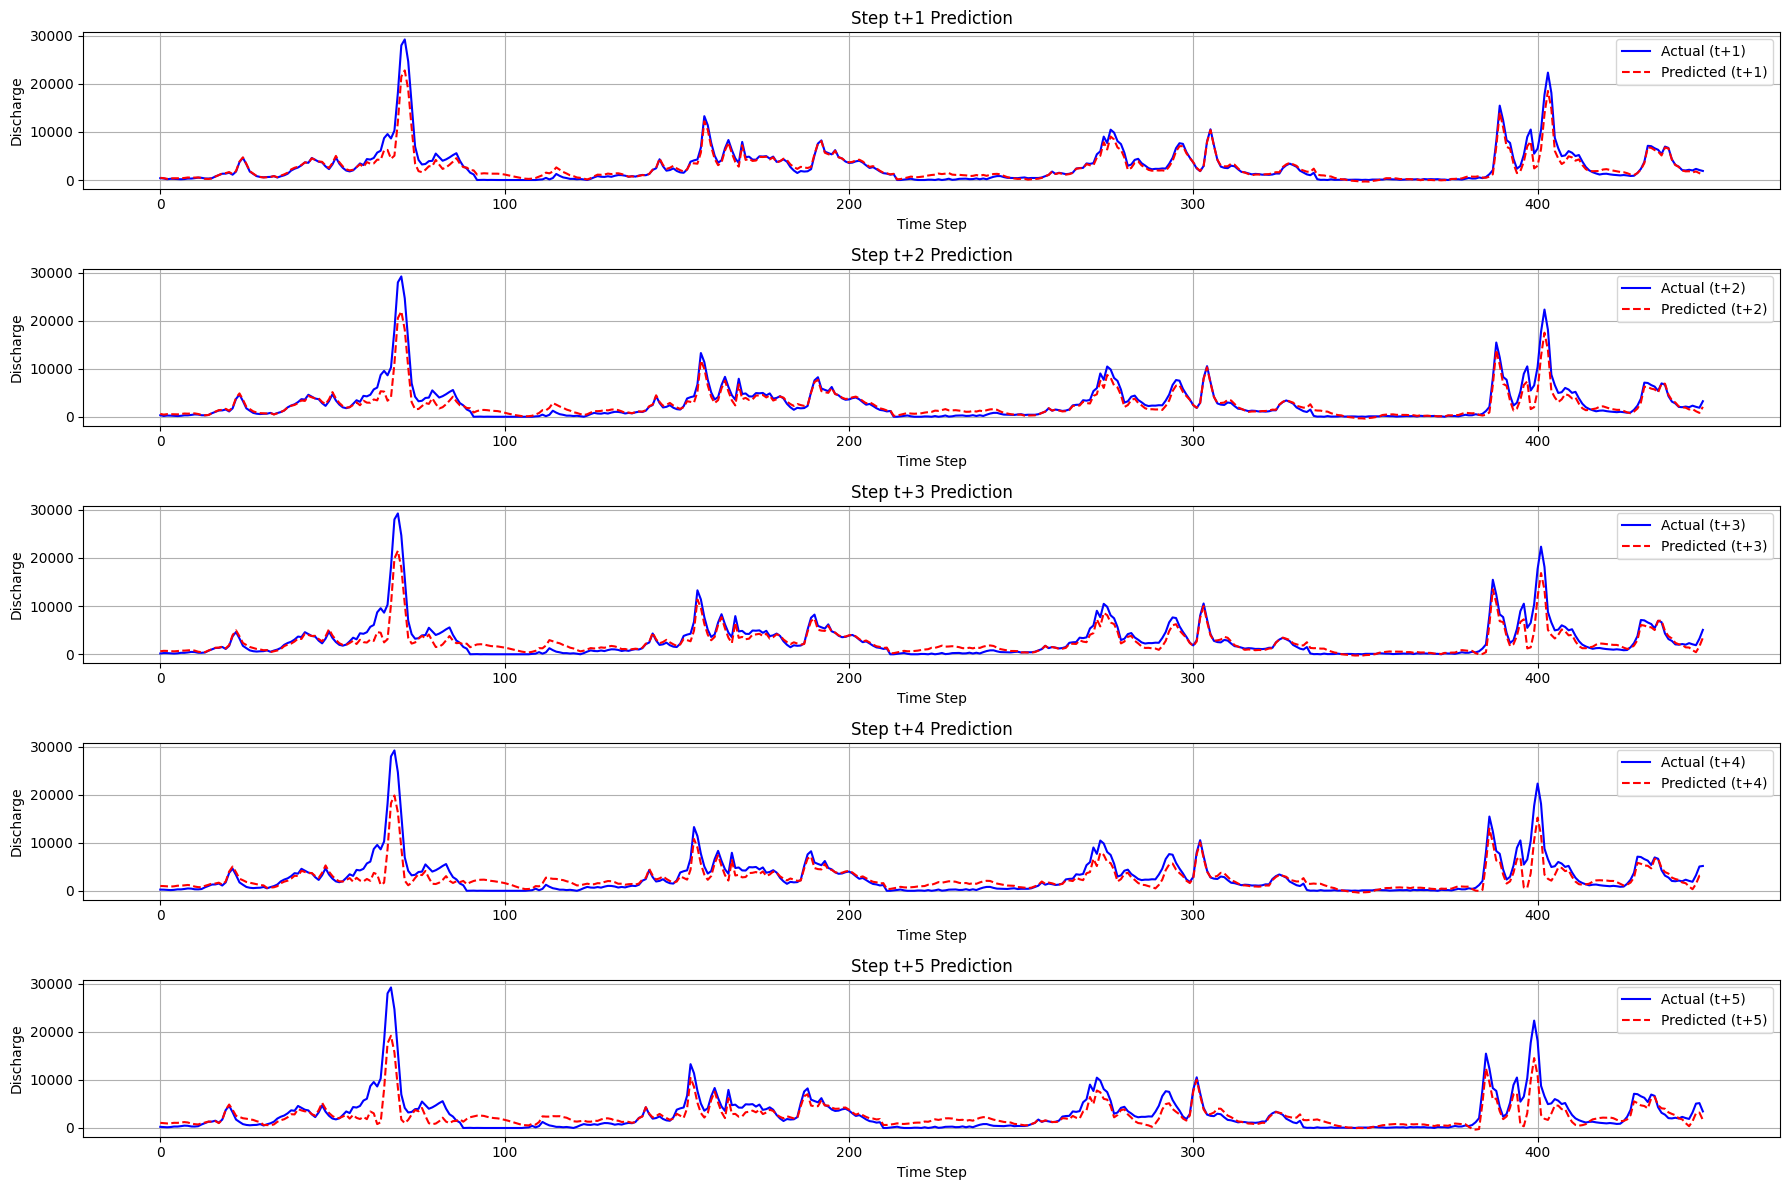

In [90]:
# Plot multiple steps ahead predictions
plt.figure(figsize=(18, 12))
steps_to_plot = min(5, N_STEPS_OUT)  # Plot up to 5 steps ahead

for i in range(steps_to_plot):
    plt.subplot(steps_to_plot, 1, i+1)
    plt.plot(y_test_raw[:, i], 'b-', label=f'Actual (t+{i+1})')
    plt.plot(y_predict_adjusted[:, i], 'r--', label=f'Predicted (t+{i+1})')
    plt.title(f'Step t+{i+1} Prediction')
    plt.xlabel('Time Step')
    plt.ylabel('Discharge')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()